In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%pip install gymnasium[mujoco]
!pip install mujoco

Note: you may need to restart the kernel to use updated packages.


State adversarial Training 
Hopper-v4
Episode 1 Reward: 132.0581424652884
Episode 2 Reward: 115.70974572533062
Episode 3 Reward: 118.22568302270442
Episode 4 Reward: 113.85295775038615
Episode 5 Reward: 123.98417258226185
Episode 6 Reward: 121.78463283761825
Episode 7 Reward: 124.48466111883126
Episode 8 Reward: 121.68185800137898
Episode 9 Reward: 115.79349420028714
Episode 10 Reward: 110.8315014912615
Episode 11 Reward: 118.3484610356512
Episode 12 Reward: 118.53273927104077
Episode 13 Reward: 115.77605720616593
Episode 14 Reward: 115.72973884428212
Episode 15 Reward: 118.48179065612867
Episode 16 Reward: 124.25938331960488
Episode 17 Reward: 126.20984196427484
Episode 18 Reward: 135.44269295738968
Episode 19 Reward: 111.3749654332397
Episode 20 Reward: 123.87571825665019
Episode 21 Reward: 115.89809289403053
Episode 22 Reward: 121.16633085574304
Episode 23 Reward: 121.22191160885863
Episode 24 Reward: 125.83163277758871
Episode 25 Reward: 113.51382397256435
Episode 26 Reward: 126.55

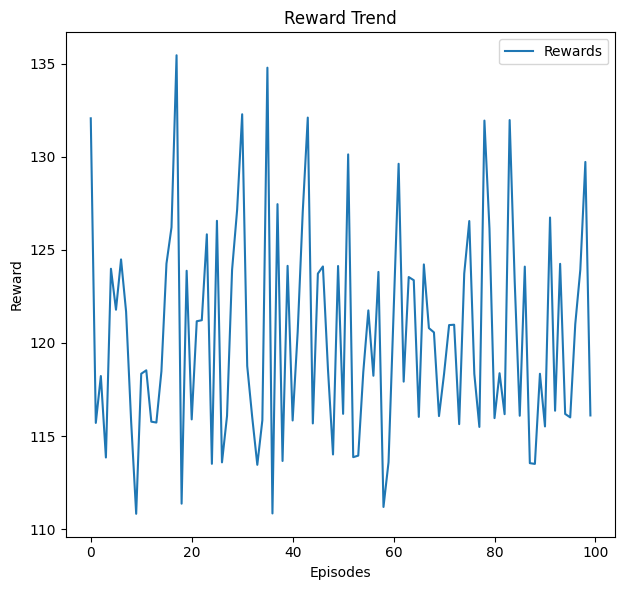

Vanilla Training
Hopper-v4
Episode 1 Reward: 11.061906030874184
Episode 2 Reward: 10.865577104379714
Episode 3 Reward: 11.104205367538116
Episode 4 Reward: 10.913478750196111
Episode 5 Reward: 11.167646049787345
Episode 6 Reward: 11.248595607383413
Episode 7 Reward: 10.926040798452917
Episode 8 Reward: 11.122714661908741
Episode 9 Reward: 11.043039836902464
Episode 10 Reward: 11.066581073198432
Episode 11 Reward: 10.91096222587185
Episode 12 Reward: 10.826437100269176
Episode 13 Reward: 11.123993197417498
Episode 14 Reward: 11.170335155107615
Episode 15 Reward: 11.033419789344451
Episode 16 Reward: 11.163168685373018
Episode 17 Reward: 10.891571805634845
Episode 18 Reward: 11.204594181924222
Episode 19 Reward: 11.24902544422138
Episode 20 Reward: 10.941846383193035
Episode 21 Reward: 11.018695471761113
Episode 22 Reward: 11.187096229654674
Episode 23 Reward: 11.0499441651604
Episode 24 Reward: 11.254545084573138
Episode 25 Reward: 10.878663275992132
Episode 26 Reward: 10.97147249348859

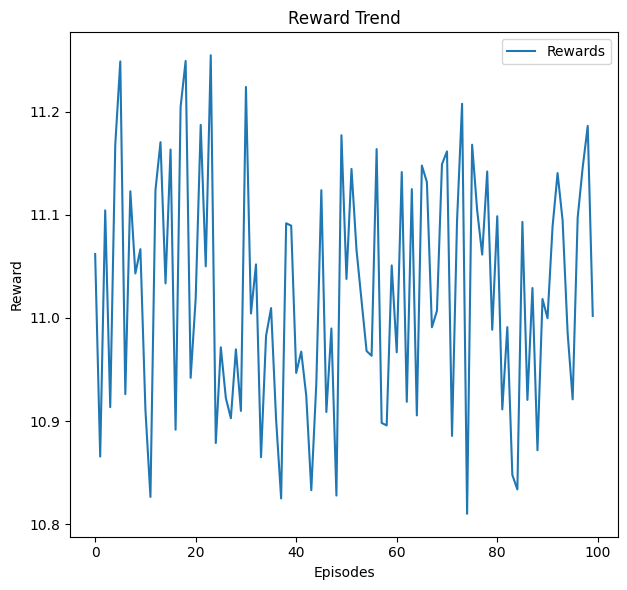

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class RandomProcess:
    def reset_states(self):
        pass

    def sample(self):
        return np.random.randn(1, 2) * 0.1

class GymTask:
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.action_space = self.env.action_space

    def reset(self):
        state, _ = self.env.reset()
        return state.astype(np.float32)

    def step(self, action):
        result = self.env.step(action)
        next_state = result[0]
        reward = result[1]
        done = result[2]
        info = result[3] if len(result) > 3 else {}
        return next_state.astype(np.float32), reward, done, info

# Define the Replay Buffer class
class ReplayBuffer:
    def __init__(self, capacity, batch_size):
        self.capacity = capacity
        self.batch_size = batch_size
        self.buffer = []
        self.position = 0

    def store(self, transition):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        indices = np.random.choice(len(self.buffer), self.batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.float32).to(device),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1).to(device),
            torch.tensor(next_states, dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(-1).to(device),
        )

    def __len__(self):
        return len(self.buffer)

# DDPG Agent class
class DDPGAgent:
    def __init__(self, task_fn, network_fn, target_network_fn, replay_buffer, gamma=0.99, attack_params=None):
        self.task = task_fn()
        self.network = network_fn().to(device)
        self.target_network = target_network_fn().to(device)
        self.replay_buffer = replay_buffer
        self.gamma = gamma
        self.attack_params = attack_params or {}

        # Sync target network with the main network
        self.target_network.load_state_dict(self.network.state_dict())

    def eval_step(self, state, state_mean, state_std):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        normalized_state = self.normalize(state, state_mean, state_std)
        with torch.no_grad():
            action = self.network.forward_actor(normalized_state)

        if self.attack_params.get("enabled", False) and self.attack_params.get("type") == "sarsa":
            action = self.sarsa_attack(state, action, state_mean, state_std)

        return action.cpu().detach().numpy().squeeze(0)

    def train_step(self, state_mean, state_std):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample()
        normalized_states = self.normalize(states, state_mean, state_std)
        normalized_next_states = self.normalize(next_states, state_mean, state_std)

        # Compute target Q-values
        with torch.no_grad():
            target_actions = self.target_network.forward_actor(normalized_next_states)
            target_q_values = self.target_network.forward_critic(normalized_next_states, target_actions)
            targets = rewards + (1 - dones) * self.gamma * target_q_values

        # Update critic
        q_values = self.network.forward_critic(normalized_states, actions)
        critic_loss = nn.MSELoss()(q_values, targets)
        self.network.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.network.critic_optimizer.step()
        loss = 0
        # Update actor with SGLD optimizer if enabled
        if self.attack_params.get("enabled", False) and "use_sgld" in self.attack_params.get("strategy", []):
            _, sgld_loss = self.sgld_actor_update(normalized_states, state_mean, state_std)
            loss = sgld_loss
        else:
            policy_loss = -self.network.forward_critic(normalized_states, self.network.forward_actor(normalized_states)).mean()
            self.network.actor_optimizer.zero_grad()
            policy_loss.backward()
            self.network.actor_optimizer.step()
            loss = policy_loss

        # Update target network
        for target_param, param in zip(self.target_network.parameters(), self.network.parameters()):
            target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)
        return loss

    def normalize(self, state, mean, std):
        return (state - mean) / std

    def denormalize(self, state, mean, std):
        return state * std + mean

    def sarsa_attack(self, state, action, state_mean, state_std):
        state = self.normalize(state, state_mean, state_std)
        target_action = action.clone().detach()
        for _ in range(self.attack_params["iteration"]):
            state.requires_grad = True
            q_value = self.network.forward_critic(state, target_action)
            loss = -torch.mean(q_value)
            self.network.critic_optimizer.zero_grad()
            loss.backward()
            with torch.no_grad():
                grad_sign = state.grad.sign()
                state += self.attack_params["alpha"] * grad_sign
                state = torch.clamp(state, -self.attack_params["epsilon"], self.attack_params["epsilon"])
            state.grad = None

        return self.network.forward_actor(state)

    def sgld_actor_update(self, states, state_mean, state_std):
        steps = self.attack_params.get("sgld_steps", 10)
        step_eps = self.attack_params.get("sgld_step_eps", 0.01)
        beta = self.attack_params.get("sgld_beta", 1e-9)

        noise_factor = torch.sqrt(torch.tensor(2 * step_eps)).to(device) * beta
        adv_states = states.clone().detach().requires_grad_()

        for _ in range(steps):
            adv_loss = (self.network.forward_actor(adv_states) - self.network.forward_actor(states)).pow(2).mean()
            adv_loss.backward()
            noise = torch.randn_like(adv_states) * noise_factor
            adv_states = (adv_states + step_eps * adv_states.grad + noise).detach().requires_grad_()
            adv_states = torch.clamp(adv_states, -3, 3)  # Clip to ensure stability

        return adv_states, adv_loss

# Define Actor-Critic Network
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, action_dim, actor_hidden, critic_hidden):
        super(ActorCriticNet, self).__init__()
        self.actor = self._build_network(state_dim, actor_hidden, action_dim, final_activation=nn.Tanh())
        self.critic = self._build_network(state_dim + action_dim, critic_hidden, 1)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-9)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-9)

    def _build_network(self, input_dim, hidden_layers, output_dim, final_activation=None):
        layers = []
        for i, hidden_dim in enumerate(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        layers.append(nn.Linear(input_dim, output_dim))
        if final_activation:
            layers.append(final_activation)
        return nn.Sequential(*layers)

    def forward_actor(self, state):
    
        return self.actor(state)

    def forward_critic(self, state, action):
        return self.critic(torch.cat([state, action], dim=1))

# Main training function
def train_ddpg(config):
    task_fn = lambda: GymTask(config["env_id"])
    print(config["env_id"])
    network_fn = lambda: ActorCriticNet(11, 3, config["training_config"]["actor_network"], config["training_config"]["critic_network"])
    target_network_fn = lambda: ActorCriticNet(11, 3, config["training_config"]["actor_network"], config["training_config"]["critic_network"])
    replay_buffer = ReplayBuffer(capacity=1000, batch_size=config["training_config"]["batch_size"])

    agent = DDPGAgent(task_fn, network_fn, target_network_fn, replay_buffer, attack_params=config["training_config"].get("attack_params", {}))

    num_episodes = config["training_config"].get("eval_episodes", 100)
    checkpoint_interval = 5

    state_mean = torch.tensor(config["data_config"]["state_mean"], dtype=torch.float32).to(device)
    state_std = torch.tensor(config["data_config"]["state_std"], dtype=torch.float32).to(device)
    Rewards = []
    Mean_Loss = []
    for episode in range(100):
        state = agent.task.reset()
        
        done = False
        episode_reward = 0
        episode_loss = []
        while not done:
            action = agent.eval_step(state, state_mean, state_std)
            next_state, reward, done, _ = agent.task.step(action)

            # Store transition in replay buffer
            agent.replay_buffer.store((state, action, reward, next_state, done))
            loss = agent.train_step(state_mean, state_std)
            state = next_state
            episode_reward += reward
        
        print(f"Episode {episode + 1} Reward: {episode_reward}")
        Rewards.append(episode_reward)
        # Mean_Loss.append(np.mean(episode_loss))
        
        # Save checkpoint
        if (episode + 1) % 100 == 0:
            torch.save(agent.network.state_dict(), f"checkpoint_episode_{episode + 1}.pth")
            print(f"Checkpoint saved for Episode {episode + 1}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(Rewards, label="Rewards")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Reward Trend")
    plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(Mean_Loss, label="Loss")
    # plt.xlabel("Episodes")
    # plt.ylabel("Loss")
    # plt.title("Loss Trend")
    # plt.legend()

    plt.tight_layout()
    plt.show()

    return agent
    
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
if __name__ == "__main__":
    # Define a sample configuration
    SA_DDPG_config = {
                    "env_id": "Hopper-v4",
                    
                    "training_config": {
                        "critic_lr": 0.0001,
                        "batch_size":64,
                        "actor_network": [400, 300, 200, 100],
                        "critic_network": [400, 300, 200, 100],
                        "robust_params": {
                            "enabled": True,
                            "strategy": [
                                "actor_l2_reg",
                                "use_sgld"
                            ],
                            "strategy_opts": {
                                "actor_reg": 100.0,
                                "critic_reg": 0.01,
                                "sgld_steps": 10,
                                "adv_ratio": 1.0
                            },
                            "eps_scheduler": {
                                "end": 0.075
            }
        },"attack_params": {
                "enabled": True,
                "type": "sarsa",
                "epsilon": 0.1,
                "alpha": 0.01,
                "iteration": 10
            }
    },
    "test_config": {
        "attack_params": {
            "eps": 0.075,
            "sarsa_action_ratio": 0.75
        },
        "sarsa_params": {
            "sarsa_reg": 0.3,
            "action_eps_scheduler": {
                "end": 0.05
            }
        }
    },
    "data_config": {
        "method": "mean_std",
        "state_mean": [
            1.41378,
            -0.04679,
            -0.11059,
            -0.25309,
            -0.10837,
            2.25122,
            0.03333,
            -0.0194,
            -0.02057,
            -0.00411,
            -0.1908
        ],
        "state_std": [
            0.1754,
            0.11278,
            0.14041,
            0.33625,
            0.64338,
            0.68419,
            1.42197,
            1.98514,
            1.86178,
            3.73027,
            5.39772
        ],
        "action_mean": [
            0.19111,
            0.40505,
            -0.19213
        ],
        "action_std": [
            0.60057,
            0.70842,
            0.79983
        ]
    }

    }
    print("State adversarial Training ")
    set_random_seed(123456)
    sa_ddpg_agent = train_ddpg(SA_DDPG_config)
    vanilla_config = {
                    "env_id": "Hopper-v4",
                    
                    "training_config": {
                        "critic_lr": 0.0001,
                        "batch_size":64,
                        "actor_network": [400, 300 ],
                        "critic_network": [400, 300],
                        "robust_params": {
                            "enabled": False,
                            "strategy": [
                                "actor_l2_reg",
                                "use_sgld"
                            ],
                            "strategy_opts": {
                                "actor_reg": 100.0,
                                "critic_reg": 0.01,
                                "sgld_steps": 10,
                                "adv_ratio": 1.0
                            },
                            "eps_scheduler": {
                                "end": 0.075
            }
        },"attack_params": {
                "enabled": False,
                "type": "sarsa",
                "epsilon": 0.1,
                "alpha": 0.01,
                "iteration": 10
            }
    },
    "test_config": {
        "attack_params": {
            "eps": 0.075,
            "sarsa_action_ratio": 0.75
        },
        "sarsa_params": {
            "sarsa_reg": 0.3,
            "action_eps_scheduler": {
                "end": 0.05
            }
        }
    },
    "data_config": {
        "method": "mean_std",
        "state_mean": [
            1.41378,
            -0.04679,
            -0.11059,
            -0.25309,
            -0.10837,
            2.25122,
            0.03333,
            -0.0194,
            -0.02057,
            -0.00411,
            -0.1908
        ],
        "state_std": [
            0.1754,
            0.11278,
            0.14041,
            0.33625,
            0.64338,
            0.68419,
            1.42197,
            1.98514,
            1.86178,
            3.73027,
            5.39772
        ],
        "action_mean": [
            0.19111,
            0.40505,
            -0.19213
        ],
        "action_std": [
            0.60057,
            0.70842,
            0.79983
        ]
    }

    }
   
    
    print("Vanilla Training")
    vanilla_agent = train_ddpg(vanilla_config)

In [29]:
def evaluate_agent_with_state_value_attack(env, actorCriticNet, epsilon, num_episodes=200, attack_steps=10, step_epsilon=0.01):
    """
    Evaluate the agent under a State Value Attack using a value network.

    Args:
        env (gym.Env): The environment.
        policy_net (torch.nn.Module): The trained policy network.
        value_net (torch.nn.Module): The trained value network.
        epsilon (float): Maximum perturbation magnitude.
        num_episodes (int): Number of episodes for evaluation.
        attack_steps (int): Number of gradient steps for the attack.
        step_epsilon (float): Step size for each gradient step.

    Returns:
        float: Average reward over the episodes under the state value attack.
    """
    device = next(actorCriticNet.actor.parameters()).device
    total_reward = 0

    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]  # Unpack if state is returned as (observation, info)
        state = torch.tensor(state, dtype=torch.float32).to(device)

        episode_reward = 0
        done = False

        while not done:
            # Start with the original state
            perturbed_state = state.clone().detach().requires_grad_(True)

            for _ in range(attack_steps):
                # Compute value for the perturbed state
                # value = actorCriticNet.forward_critic(perturbed_state.unsqueeze(0))

                perturbation = step_epsilon
                perturbed_state = (perturbed_state + perturbation).detach().requires_grad_(True)

                # Clamp the perturbed state to within the epsilon-ball
                perturbed_state = torch.max(
                    torch.min(perturbed_state, state + epsilon), state - epsilon
                ).detach().requires_grad_(True)

            # Use the perturbed state to select the action
            with torch.no_grad():
                action_output = actorCriticNet.forward_actor(perturbed_state.unsqueeze(0))
                if isinstance(action_output, tuple):
                    action = action_output[0]  # Extract mean for continuous actions
                else:
                    action = action_output

                action = action.squeeze().cpu().numpy()  # Ensure the action is in NumPy format

            # Step the environment
            next_step_result = env.step(action)
            if isinstance(next_step_result, tuple):
                next_state, reward, done, _, _ = next_step_result
            else:
                next_state, reward, done = next_step_result[:3]

            # Accumulate the reward
            episode_reward += reward

            # Update the state
            state = torch.tensor(next_state, dtype=torch.float32).to(device)

        total_reward += episode_reward
        print(f"Episode {episode + 1}/{num_episodes}: Reward = {episode_reward}")

    average_reward = total_reward / num_episodes
    print(f"Average Reward under State Value Attack: {average_reward}")
    return average_reward


In [30]:
env = GymTask("Hopper-v4").env
evaluate_agent_with_state_value_attack(
    env,
    sa_ddpg_agent.network,
    epsilon=0.075,
    num_episodes=20,
    attack_steps=10,
    step_epsilon=0.01,
)

Episode 1/20: Reward = 148.85011590397858
Episode 2/20: Reward = 137.9292865407137
Episode 3/20: Reward = 158.40119987366086
Episode 4/20: Reward = 154.56220002153418
Episode 5/20: Reward = 148.86725034019156
Episode 6/20: Reward = 151.2139561820733
Episode 7/20: Reward = 143.59048620107757
Episode 8/20: Reward = 154.5572147902671
Episode 9/20: Reward = 141.19907253388132
Episode 10/20: Reward = 158.3765948627482
Episode 11/20: Reward = 148.38686800577418
Episode 12/20: Reward = 140.23956040228066
Episode 13/20: Reward = 155.0915254341556
Episode 14/20: Reward = 155.51980776292584
Episode 15/20: Reward = 145.88671873161647
Episode 16/20: Reward = 149.0097130987871
Episode 17/20: Reward = 167.29590415334366
Episode 18/20: Reward = 148.99524884571437
Episode 19/20: Reward = 160.97033545433538
Episode 20/20: Reward = 143.42166077494474
Average Reward under State Value Attack: 150.6182359957002


150.6182359957002

In [33]:
env = GymTask("Hopper-v4").env
evaluate_agent_with_state_value_attack(
    env,
    vanilla_agent.network,
    epsilon=0.075,
    num_episodes=20,
    attack_steps=10,
    step_epsilon=0.01,
)

Episode 1/20: Reward = 16.464374677864118
Episode 2/20: Reward = 15.950235452042769
Episode 3/20: Reward = 16.572641349904686
Episode 4/20: Reward = 16.54382577263031
Episode 5/20: Reward = 16.05861544759833
Episode 6/20: Reward = 16.550880428861603
Episode 7/20: Reward = 16.304450707657146
Episode 8/20: Reward = 16.00036039312044
Episode 9/20: Reward = 16.015033730025017
Episode 10/20: Reward = 15.886946943470358
Episode 11/20: Reward = 16.45078828763696
Episode 12/20: Reward = 16.72229773195948
Episode 13/20: Reward = 16.005426161061113
Episode 14/20: Reward = 16.43915411930901
Episode 15/20: Reward = 16.423086412002565
Episode 16/20: Reward = 16.59073242285286
Episode 17/20: Reward = 16.621196031816954
Episode 18/20: Reward = 16.245360016465778
Episode 19/20: Reward = 16.38179238555706
Episode 20/20: Reward = 15.957687870201264
Average Reward under State Value Attack: 16.309244317101893


16.309244317101893

In [50]:
def evaluate_agent(env, policy_net, num_episodes=200, render=False):
    """
    Evaluates the trained policy network on the environment.

    Args:
    - env: The Gym environment.
    - policy_net: The trained policy network.
    - num_episodes: Number of episodes to evaluate.
    - render: Whether to render the environment during evaluation.

    Returns:
    - Average reward over the evaluated episodes.
    """
    device = next(policy_net.parameters()).device
    total_rewards = []

    for episode in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            state = reset_result[0]
        else:
            state = reset_result

        if not isinstance(state, np.ndarray):
            state = np.array(state, dtype=np.float32)

        episode_reward = 0
        terminated, truncated = False, False

        while not (terminated or truncated):
            if render:
                env.render()

            # Move the state tensor to the same device as the policy network
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                policy_output = policy_net(state_tensor).cpu().numpy()
            
            action = policy_output.squeeze()
            
            # Take a step in the environment
            next_step_result = env.step(action)
            if isinstance(next_step_result, tuple):
                next_state, reward, terminated, truncated, _ = next_step_result
            else:
                next_state, reward, terminated, truncated = next_step_result[:4]

            episode_reward += reward
            state = next_state

        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    average_reward = sum(total_rewards) / num_episodes
    print(f"Average Reward over {num_episodes} Episodes: {average_reward}")
    return average_reward


In [51]:
evaluate_agent(env, sa_ddpg_agent.network.actor, num_episodes=20, render=False)

Episode 1: Reward = 162.46206026872167
Episode 2: Reward = 161.54599255665534
Episode 3: Reward = 177.06462340305646
Episode 4: Reward = 189.02099905131593
Episode 5: Reward = 165.09043323897026
Episode 6: Reward = 162.0042174972359
Episode 7: Reward = 165.33561251573212
Episode 8: Reward = 164.88639716261144
Episode 9: Reward = 159.38314939530343
Episode 10: Reward = 186.5196775604358
Episode 11: Reward = 174.65227859692345
Episode 12: Reward = 165.02209434758313
Episode 13: Reward = 170.40681962311515
Episode 14: Reward = 175.92474642523788
Episode 15: Reward = 176.3167772990616
Episode 16: Reward = 186.7446416289107
Episode 17: Reward = 191.72880118295257
Episode 18: Reward = 185.74788573337162
Episode 19: Reward = 165.26865773667726
Episode 20: Reward = 173.14825616575703
Average Reward over 20 Episodes: 172.91370606948144


172.91370606948144

In [52]:
evaluate_agent(env, vanilla_agent.network.actor, num_episodes=20, render=False)

Episode 1: Reward = 15.332058536948134
Episode 2: Reward = 15.340826930247198
Episode 3: Reward = 15.865076594400906
Episode 4: Reward = 15.831342469265193
Episode 5: Reward = 16.15876534575611
Episode 6: Reward = 15.322327015022195
Episode 7: Reward = 15.770923436610659
Episode 8: Reward = 15.164919394177527
Episode 9: Reward = 15.410843882896177
Episode 10: Reward = 15.885099984208711
Episode 11: Reward = 15.221151542488442
Episode 12: Reward = 15.245873106918419
Episode 13: Reward = 15.50383524961218
Episode 14: Reward = 15.820644706828435
Episode 15: Reward = 15.556146241178322
Episode 16: Reward = 15.876401171583819
Episode 17: Reward = 15.95604444936759
Episode 18: Reward = 15.565513071321528
Episode 19: Reward = 16.02356786565414
Episode 20: Reward = 15.232078489996294
Average Reward over 20 Episodes: 15.604171974224098


15.604171974224098